# Classification Automatique de Produits par Extraction de Caractéristiques d'Images

<a id='sec:introduction'></a>
# I. Introduction

Dans la poursuite de notre projet de science des données visant à automatiser la classification de produits, nous abordons désormais la phase cruciale d'extraction de caractéristiques à partir d'images. Cette étape joue un rôle clé dans la compréhension et la représentation des informations visuelles contenues dans les images des produits. Nous explorerons diverses techniques telles que SIFT, ORB, SURF ainsi que le transfert d'apprentissage avec les réseaux de neurones convolutifs (CNN) pour extraire ces caractéristiques.

L'objectif principal de cette phase est de traduire les attributs visuels des produits en des représentations numériques significatives. Nous souhaitons ainsi permettre à notre système de classification d'appréhender les nuances subtiles et les détails visuels des images de produits, facilitant ainsi une classification précise et automatisée.

De plus, dans cette partie, nous franchirons une étape supplémentaire en explorant les techniques de "data augmentation". Cette approche vise à enrichir notre ensemble de données d'entraînement en générant de nouvelles images à partir des images originales, tout en conservant leur sens et leur signification. Ce processus de renforcement de données contribue à améliorer les performances de notre modèle en garantissant sa capacité à généraliser à des situations nouvelles et variées.

Au cours de cette étape de l'extraction de caractéristiques et de la classification supervisée basée sur les images, nous aspirons à construire un modèle robuste et efficace qui sera capable de prendre des décisions de classification éclairées à partir d'images de produits, contribuant ainsi à l'automatisation et à l'efficacité des processus de classification au sein de notre contexte industriel.

## Importation

In [1]:
# pour editer le jeu de donne
import pandas as pd
import numpy as np
import datetime as dt
import time
from IPython.display import Image
# pour visualiser 
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import plotly.express as px
import plotly.figure_factory as ff
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import chart_studio.plotly as py
import cufflinks as cf 
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import importlib.metadata
from scipy import stats
import os
import imagesize

# For Notebooks
init_notebook_mode(connected=True)
# For offline use
cf.go_offline()
%matplotlib inline

In [2]:
!python --version

print('\nfully imported')
print('\n'.join(f'{m.__name__} - {m.__version__}' 
                for m in globals().values() 
                if getattr(m, '__version__', None)))

print('\npartially imported')
print("deep_translator -", importlib.metadata.version('deep_translator'))
print("importlib -", importlib.metadata.version('importlib.metadata'))
print("matplotlib -", importlib.metadata.version('matplotlib'))
print("numpy -", importlib.metadata.version('numpy'))

Python 3.8.3

fully imported
pandas - 2.0.3
numpy - 1.23.5
seaborn - 0.12.2
missingno - 0.4.2
cufflinks - 0.17.3

partially imported
deep_translator - 1.11.4
importlib - 6.6.0
matplotlib - 3.6.2
numpy - 1.23.5


### Table des Matières
- [I. Introduction](#sec:introduction)
- [II. Prétraitement de l'Image](#sec:pretraitement-image)
    - [A. Prétraitement de Base](#subsec:pretraitement-base)
    - [B. Détection des Points Clés (SIFT)](#subsec:detection-points-cles)
- [III. Analyse avec Transfert d'Apprentissage](#sec:analyse-transfert-apprentissage)
    - [A. Extraction des Caractéristiques avec VGG16](#subsec:extraction-caracteristiques-vgg16)
    - [B. Réduction de Dimension avec t-SNE](#subsec:reduction-dimension-pca-tsne)
    - [C. Visualisation avec t-SNE](#subsec:visualisation-tsne)
- [IV. Conclusion](#sec:conclusion)

<a id='sec:pretraitement-image'></a>
## II. Prétraitement de l'Image

Les dimensions des images sont obtenues à l'aide de la bibliothèque "imagesize". Les dimensions sont ensuite traitées et stockées dans le DataFrame, et des statistiques descriptives sont affichées pour mieux comprendre les données.

<a id ='subsec:pretraitement-base'><a/>    
### A. Prétraitement de Base


In [3]:
# Valeur pour remplir les cases manquantes dans le DataFrame
nan_value = np.nan

# Liste des fichiers d'images dans le répertoire "Flipkart/Images"
list_files = os.listdir("Flipkart/Images")

# Création d'un DataFrame pour stocker les informations sur les images
df_images = pd.DataFrame(nan_value,
                         index=range(0, len(list_files)),
                         columns=['Name', 'Width', 'Height', 'Ratio', 'Size'])

# Compteur pour parcourir les fichiers et remplir le DataFrame
counter = 0
for file in list_files :
    # Récupération des dimensions de l'image à l'aide de la bibliothèque "imagesize"
    width, height = imagesize.get("Flipkart/Images/{}".format(file))
    # Remplissage des informations dans le DataFrame
    df_images.loc[counter] = [file, width, height, width / height, width * height]
    counter += 1
del counter, file

# Conversion des colonnes 'Width', 'Height' et 'Size' en types entiers
df_images[['Width', 'Height', 'Size']] = df_images[['Width', 'Height', 'Size']].astype('int32')

# Affichage des informations du DataFrame
df_images.info()

# Affichage des premières lignes du DataFrame
display(df_images.head())

# Affichage des statistiques descriptives du DataFrame
display(df_images.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Name    1050 non-null   object 
 1   Width   1050 non-null   int32  
 2   Height  1050 non-null   int32  
 3   Ratio   1050 non-null   float64
 4   Size    1050 non-null   int32  
dtypes: float64(1), int32(3), object(1)
memory usage: 28.8+ KB


,Name,Width,Height,Ratio,Size
0,aa68675f50a0551b8dadb954017a50a1.jpg,3600,1188,3.030303,4276800
1,037c2402fee39fbc80433935711d1383.jpg,1136,657,1.729072,746352
2,42643c1c9403f67921a18654bcf45ead.jpg,948,1184,0.800676,1122432
3,53f4bc7d7321f5c41de6b86e41f13e80.jpg,2000,1900,1.052632,3800000
4,b144a363c107c7bdd91f32d6e28ba6f2.jpg,409,930,0.439785,380370


,Width,Height,Ratio,Size
count,1050.000000,1050.000000,1050.000000,1.050000e+03
mean,1174.124762,1192.207619,1.050537,1.718621e+06
std,791.606795,609.124232,0.524490,2.259012e+06
min,145.000000,160.000000,0.117172,5.800000e+04
25%,747.250000,844.000000,0.676975,6.723750e+05
50%,1100.000000,1100.000000,0.997812,1.015850e+06
75%,1201.000000,1360.000000,1.303318,1.553940e+06
max,6000.000000,3171.000000,4.359155,1.777980e+07


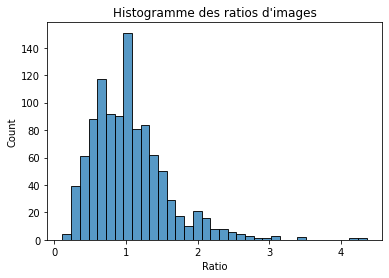

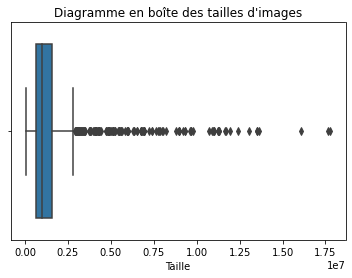

In [4]:
# Affichage de l'histogramme des ratios d'images
sns.histplot(data=df_images, x="Ratio")
plt.xlabel("Ratio")
plt.title("Histogramme des ratios d'images")
plt.show()

# Affichage du diagramme en boîte des tailles d'images
sns.boxplot(data=df_images, x="Size")
plt.xlabel("Taille")
plt.title("Diagramme en boîte des tailles d'images")
plt.show()

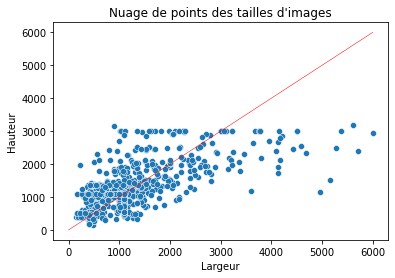

In [5]:
# Calcul de la valeur maximale entre les largeurs et hauteurs d'images
max_w_h = max(df_images["Width"].max(), df_images["Height"].max())

# Tracé d'une ligne diagonale pour comparer largeurs et hauteurs
plt.plot([0, max_w_h], [0, max_w_h], linewidth=0.5, color='r')

# Tracé d'un nuage de points pour représenter les largeurs et hauteurs
sns.scatterplot(x=df_images["Width"], y=df_images['Height'])
plt.xlabel("Largeur")
plt.ylabel("Hauteur")
plt.title("Nuage de points des tailles d'images")
plt.show()

In [6]:
df_images['Height'].sort_values(ascending=False).head(10)

58     3171
129    3141
170    3000
603    3000
976    3000
292    3000
963    3000
281    3000
494    3000
884    3000
Name: Height, dtype: int32

In [7]:
df_images.iloc[249]

Name      5518124b75d6c6dfee4c2e4c0cfa716a.jpg
Width                                     2305
Height                                    3000
Ratio                                 0.768333
Size                                   6915000
Name: 249, dtype: object

In [8]:
from PIL import Image

# Liste des indices à modifier
indices_to_modify = list(df_images['Height'].sort_values(ascending=False).head(10).index)
# Hauteur souhaitée
new_height = 3000

# Chargement et modification de chaque image
for index in indices_to_modify:
    # Chargement de l'image originale
    chemin_image_originale = f'Flipkart/Images/{df_images.iloc[index]["Name"]}' 
    # Mettez à jour ce chemin en fonction de votre jeu de données
    image_originale = Image.open(chemin_image_originale)
    
    # Calcul de la largeur correspondante pour maintenir le rapport d'aspect
    new_width = int(new_height * image_originale.width / image_originale.height)
    
    # Redimensionnement de l'image
    image_redimensionnee = image_originale.resize((new_width, new_height), Image.ANTIALIAS)
    
    # Sauvegarde de l'image redimensionnée dans le chemin du fichier d'origine
    image_redimensionnee.save(chemin_image_originale)
    
    print(f"Image redimensionnée et enregistrée à l'indice {index}")

print("Toutes les images ont été redimensionnées et enregistrées.")


Image redimensionnée et enregistrée à l'indice 58
Image redimensionnée et enregistrée à l'indice 129
Image redimensionnée et enregistrée à l'indice 170
Image redimensionnée et enregistrée à l'indice 603
Image redimensionnée et enregistrée à l'indice 976
Image redimensionnée et enregistrée à l'indice 292
Image redimensionnée et enregistrée à l'indice 963
Image redimensionnée et enregistrée à l'indice 281
Image redimensionnée et enregistrée à l'indice 494
Image redimensionnée et enregistrée à l'indice 884
Toutes les images ont été redimensionnées et enregistrées.


In [10]:
df = pd.read_csv('flipkart_com-ecommerce_sample_1050.csv')

In [11]:
# Fonction pour extraire les noms de catégories
def extraire_categories(ligne):
    categories = eval(ligne['product_category_tree'])  # Convertir la chaîne de catégories en liste
    return [categorie.strip() for categorie in categories[0].split('>>')]  # Diviser et nettoyer les catégories

# Appliquer la fonction au DataFrame
df['categories'] = df.apply(extraire_categories, axis=1)  # Créer une nouvelle colonne 'categories'

# Créer des colonnes distinctes pour chaque catégorie
max_categories = max(df['categories'].apply(len))  # Trouver le nombre maximal de catégories dans une ligne
for i in range(max_categories):
    df[f'Cat_{i+1}'] = df['categories'].apply(lambda x: x[i] if len(x) > i else None)  # Créer des colonnes pour chaque catégorie

# Supprimer la colonne originale 'categories'
df.drop('categories', axis=1, inplace=True)

In [12]:
list_photos = df['image']

In [13]:
from sklearn import preprocessing

# Obtenir les valeurs uniques de la colonne 'Cat_1'
list_labels = df['Cat_1'].unique()
display(list_labels)

# Initialiser un encodeur de libellé
le = preprocessing.LabelEncoder()

# Appliquer l'encodage aux valeurs de la colonne 'Cat_1' et les stocker dans une nouvelle colonne 'label'
df["label"] = le.fit_transform(df["Cat_1"])



array(['Home Furnishing', 'Baby Care', 'Watches',
       'Home Decor & Festive Needs', 'Kitchen & Dining',
       'Beauty and Personal Care', 'Computers'], dtype=object)

In [14]:
df.groupby("label").count()['Cat_1']

label
0    150
1    150
2    150
3    150
4    150
5    150
6    150
Name: Cat_1, dtype: int64

In [15]:
df['label_name'] = df['Cat_1']

Home Furnishing


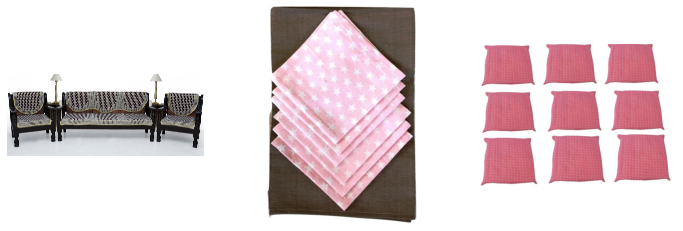

Baby Care


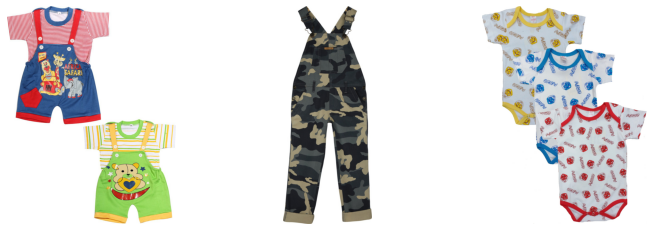

Watches


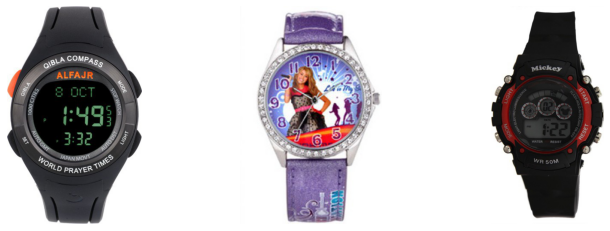

Home Decor & Festive Needs


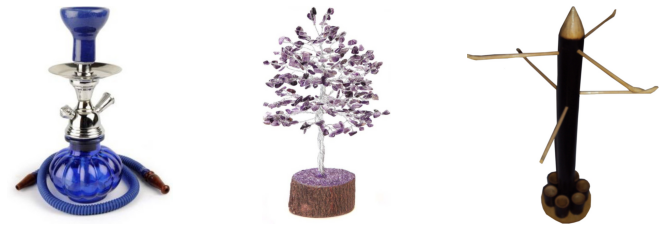

Kitchen & Dining


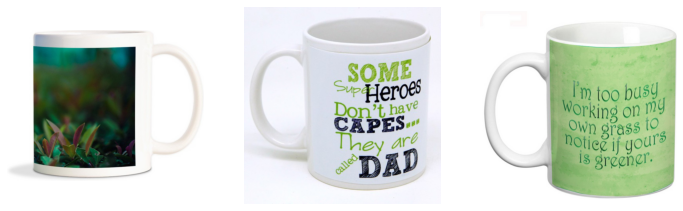

Beauty and Personal Care


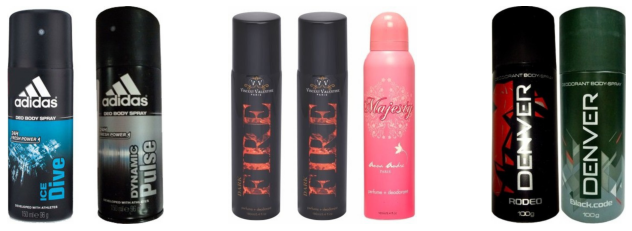

Computers


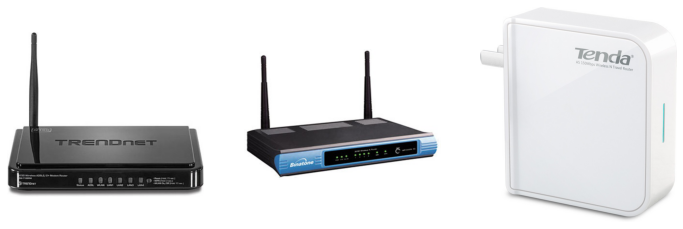

In [16]:
from matplotlib.image import imread

def list_fct(name):
    list_image_name = [list_photos[i] for i in range(len(df)) if df["label_name"][i] == name]
    return list_image_name

# Obtenir les valeurs uniques de la colonne 'label_name'
list_labels = df['label_name'].unique()

for name in list_labels:
    print(name)
    plt.figure(figsize=(12, 4))
    
    # Obtenir la liste des noms de fichiers pour l'étiquette actuelle
    file_list = list_fct(name)
    path = 'Flipkart/Images'  # Fournir le chemin correct vers votre répertoire d'images
    
    # Afficher des images de l'étiquette spécifiée
    for i in range(3):
        plt.subplot(130 + 1 + i)
        filename = path + '/' + file_list[i+20]  # Utiliser l'index correct
        image = imread(filename)
        plt.imshow(image)
        plt.axis('off')
    
    plt.show()



<a id='subsec:detection-points-cles'></a>
### <span style="color:red">B. Détection des Points Clés (SIFT)</span>

#### Étude des Caractéristiques d'Images avec l'Extracteur SIFT de OpenCV

Ce code utilise OpenCV pour appliquer l'extracteur de caractéristiques SIFT (Scale-Invariant Feature Transform) à une image en niveaux de gris. Il détecte les points clés dans l'image, calcule les descripteurs SIFT correspondants et les affiche. Les points clés sont dessinés sur l'image pour mettre en évidence les régions d'intérêt. Les informations sur la forme et le type de l'image sont affichées, ainsi que la forme et les valeurs des descripteurs calculés.

In [17]:
list_photos[1]

'7b72c92c2f6c40268628ec5f14c6d590.jpg'

Forme de l'image : (844, 1100)
Type de l'image : uint8


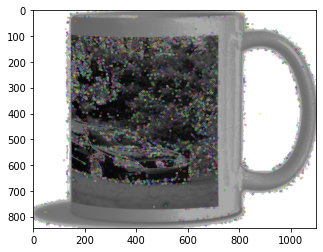

Forme des descripteurs : (3485, 128)

[[  0.   0.   0. ...   0.   0.   0.]
 [ 20.   0.   0. ...   0.   0.   0.]
 [ 17.  19.   9. ...   0.   0.   0.]
 ...
 [122.   4.   0. ...   0.   0.   1.]
 [148.  21.   0. ...   0.   0.   1.]
 [ 43.   8.   0. ...   0.   0.   0.]]


In [18]:
import cv2.xfeatures2d

# Initialiser l'extracteur de caractéristiques SIFT
sift = cv2.SIFT_create()

# Charger l'image en niveaux de gris
image = cv2.imread(path + '/' + list_photos[160], 0)

# Afficher les informations sur la forme et le type de l'image
print("Forme de l'image :", image.shape)
print("Type de l'image :", image.dtype)

# Égaliser l'histogramme de l'image
image = cv2.equalizeHist(image)

# Détecter et calculer les descripteurs SIFT
kp, des = sift.detectAndCompute(image, None)

# Dessiner les points clés sur l'image
img = cv2.drawKeypoints(image, kp, image)

# Afficher l'image avec les points clés
plt.imshow(img)
plt.show()

# Afficher la forme des descripteurs et les descripteurs eux-mêmes
print("Forme des descripteurs :", des.shape)
print()
print(des)

In [19]:
# Identification des points clés et extraction des descripteurs associés

import time, cv2

# Initialisation d'une liste pour stocker les descripteurs SIFT
sift_keypoints = []

# Mesure du temps de début
temps1=time.time()

# Création de l'extracteur de descripteurs SIFT avec un nombre maximal de 500 points clés
sift = cv2.SIFT_create(500)

# Parcours de chaque image dans le jeu de données
for image_num in range(len(list_photos)) :
    # Affichage du numéro de l'image à chaque multiple de 100
    if image_num % 100 == 0:
        print(image_num)
    
    # Chargement de l'image en niveaux de gris depuis le chemin spécifié
    image = cv2.imread(path+'/'+list_photos[image_num],0)
    
    # Égalisation de l'histogramme de l'image pour améliorer la qualité
    res = cv2.equalizeHist(image)
    
    # Détection des points clés et extraction des descripteurs associés
    kp, des = sift.detectAndCompute(res, None)
    
    # Ajout des descripteurs à la liste
    sift_keypoints.append(des)

# Conversion de la liste de descripteurs en un tableau NumPy
sift_keypoints_by_img = np.asarray(sift_keypoints, dtype=object)

# Concaténation de tous les descripteurs pour une analyse globale
sift_keypoints_all = np.concatenate(sift_keypoints_by_img, axis=0)

# Affichage du nombre total de descripteurs extraits
print()
print("Nombre de descripteurs : ", sift_keypoints_all.shape)

# Calcul de la durée totale de traitement
duration1 = time.time() - temps1
print("Temps de traitement des descripteurs SIFT : ", "%15.2f" % duration1, "secondes")


0
100
200
300
400
500
600
700
800
900
1000

Nombre de descripteurs :  (517357, 128)
Temps de traitement des descripteurs SIFT :           309.90 secondes


Le nombre de clusters est estimé en utilisant la racine carrée du nombre total de descripteurs SIFT. Ensuite, un modèle de clustering KMeans est créé avec le nombre de clusters déterminé. Le modèle est entraîné sur l'ensemble des descripteurs SIFT à l'aide de la méthode fit()

In [60]:
from sklearn import cluster, metrics

# Détermination du nombre de clusters
temps1 = time.time()

# Estimation du nombre de clusters en utilisant la racine carrée du nombre total de descripteurs SIFT
k = int(round(np.sqrt(len(sift_keypoints_all)), 0))
print("Nombre de clusters estimés : ", k)
print("Création de", k, "clusters de descripteurs ...")

# Création du modèle de clustering KMeans
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0, n_init=10)

# Entraînement du modèle de clustering sur les descripteurs SIFT
kmeans.fit(sift_keypoints_all)

# Calcul de la durée totale de traitement
duration1 = time.time() - temps1
print("Temps de traitement du clustering KMeans : ", "%15.2f" % duration1, "secondes")


Nombre de clusters estimés :  719
Création de 719 clusters de descripteurs ...
Temps de traitement du clustering KMeans :             7.76 secondes


Ce code crée des histogrammes de caractéristiques en utilisant les résultats du clustering KMeans. La fonction build_histogram prend les résultats du clustering (étiquettes de clusters) pour un ensemble de descripteurs SIFT d'une image donnée et construit un histogramme normalisé. Ensuite, une matrice d'histogrammes est construite pour toutes les images en utilisant cette fonction. Chaque ligne de la matrice représente un histogramme de caractéristiques pour une image donnée. La durée totale de création des histogrammes est calculée et affichée à la fin.

In [61]:
# Création des histogrammes (caractéristiques)
temps1 = time.time()

# Fonction pour construire un histogramme à partir des résultats du clustering KMeans
def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des = len(des)
    if nb_des == 0:
        print("Problème avec l'histogramme de l'image : ", image_num)
    for i in res:
        hist[i] += 1.0 / nb_des
    return hist

# Création d'une matrice d'histogrammes
hist_vectors = []

for i, image_desc in enumerate(sift_keypoints_by_img):
    if i % 100 == 0:
        print(i)
    hist = build_histogram(kmeans, image_desc, i)  # Calcule l'histogramme
    hist_vectors.append(hist)  # L'histogramme est le vecteur de caractéristiques

im_features = np.asarray(hist_vectors)

duration1 = time.time() - temps1
print("Temps de création des histogrammes : ", "%15.2f" % duration1, "secondes")

0
100
200
300
400
500
600
700
800
900
1000
Temps de création des histogrammes :             1.01 secondes


In [62]:
from sklearn import manifold, decomposition

# Réduction de dimensions avec PCA
print("Dimensions du jeu de données avant réduction PCA : ", im_features.shape)

# Création de l'objet PCA avec une limite de 99% de la variance expliquée
pca = decomposition.PCA(n_components=0.99)

# Réduction de dimensions du jeu de données avec PCA
feat_pca = pca.fit_transform(im_features)

print("Dimensions du jeu de données après réduction PCA : ", feat_pca.shape)


Dimensions du jeu de données avant réduction PCA :  (1050, 719)
Dimensions du jeu de données après réduction PCA :  (1050, 500)


In [65]:
from sklearn import manifold, decomposition

# Configuration du modèle t-SNE
tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=10)

# Réduction de dimensions du jeu de données PCA avec t-SNE
X_tsne = tsne.fit_transform(feat_pca)

# Création d'un DataFrame avec les coordonnées t-SNE et les étiquettes de classe
df_tsne = pd.DataFrame(X_tsne[:, 0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = df["label_name"]

# Affichage de la forme (nombre de lignes et de colonnes) du DataFrame
print(df_tsne.shape)

(1050, 3)


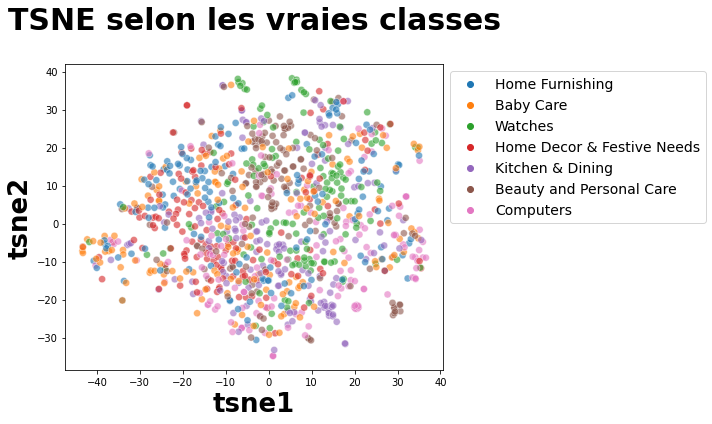

In [66]:
# Création du diagramme de dispersion (scatter plot)
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne,
    palette=sns.color_palette('tab10', n_colors=len(df_tsne["class"].unique())), s=50, alpha=0.6
)

# Déplacer la légende en dehors du graphique
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 14})

# Ajout du titre et des étiquettes
plt.title('TSNE selon les vraies classes', fontsize=30, pad=35, fontweight='bold')
plt.xlabel('tsne1', fontsize=26, fontweight='bold')
plt.ylabel('tsne2', fontsize=26, fontweight='bold')

plt.tight_layout()  # Assurer que tout s'adapte correctement
plt.show()

In [67]:
from sklearn import cluster, metrics

# Application de la méthode de clustering KMeans aux données transformées par t-SNE
cls = cluster.KMeans(n_clusters=7, random_state=6, n_init=10)
cls.fit(X_tsne)

# Ajout des étiquettes de clusters au DataFrame t-SNE
df_tsne["cluster"] = cls.labels_


ARI :  0.045216027325478775


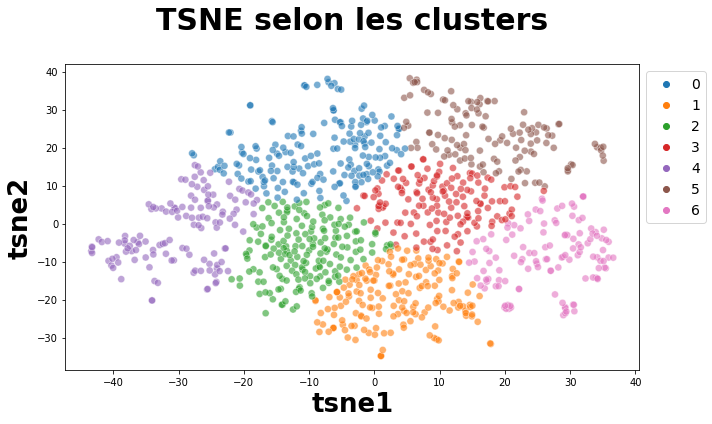

In [68]:
# Visualisation des clusters t-SNE
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=len(df_tsne["cluster"].unique())),
    s=50, alpha=0.6,
    data=df_tsne
)

# Déplacement de la légende à l'extérieur du graphique
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 14})

# Ajout du titre et des étiquettes
plt.title('TSNE selon les clusters', fontsize=30, pad=35, fontweight='bold')
plt.xlabel('tsne1', fontsize=26, fontweight='bold')
plt.ylabel('tsne2', fontsize=26, fontweight='bold')

plt.tight_layout()

# Calcul de l'indice de Rand ajusté (ARI)
labels = df["label"]
ari = metrics.adjusted_rand_score(labels, cls.labels_)
print("ARI : ", ari)

plt.show()


Analyse :

L'analyse démontre l'extraction de caractéristiques informatives à partir d'images en utilisant SIFT.
Le regroupement K-Means et la création d'histogrammes aident à organiser et à représenter les caractéristiques des images.
La réduction de la dimensionnalité avec PCA et t-SNE permet une visualisation et un regroupement efficaces.
L'évaluation, en utilisant l'ARI, évalue la qualité du regroupement et peut être utilisée pour des ajustements ultérieurs.

In [69]:
# Regroupement et comptage des instances dans chaque cluster
df_tsne.groupby("cluster").count()["class"]

cluster
0    178
1    172
2    176
3    145
4    131
5    124
6    124
Name: class, dtype: int64

In [70]:
# Matrice de confusion
conf_mat = metrics.confusion_matrix(labels, cls.labels_)
print(conf_mat)

[[24 23 22 15 37 13 16]
 [49 12 15 37  8 14 15]
 [ 7 31 23 17  8 12 52]
 [21 18 50 10 33 12  6]
 [37 17 13 15 30 25 13]
 [14 47 39 13  9 18 10]
 [26 24 14 38  6 30 12]]


In [71]:
# Transformation des étiquettes de cluster
np.argmax(conf_mat, axis=0)

array([1, 5, 3, 6, 0, 6, 2])

In [73]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    corresp = [1, 5, 3, 4, 0, 6, 2]
    
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

# Transformation des étiquettes de cluster
cls_labels_transform = conf_mat_transform(labels, cls.labels_)

# Matrice de confusion après transformation
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)
print(conf_mat)

# Rapport de classification
print(metrics.classification_report(labels, cls_labels_transform))

Correspondance des clusters :  [1, 5, 3, 4, 0, 6, 2]
[[37 24 16 22 15 23 13]
 [ 8 49 15 15 37 12 14]
 [ 8  7 52 23 17 31 12]
 [33 21  6 50 10 18 12]
 [30 37 13 13 15 17 25]
 [ 9 14 10 39 13 47 18]
 [ 6 26 12 14 38 24 30]]
              precision    recall  f1-score   support

           0       0.28      0.25      0.26       150
           1       0.28      0.33      0.30       150
           2       0.42      0.35      0.38       150
           3       0.28      0.33      0.31       150
           4       0.10      0.10      0.10       150
           5       0.27      0.31      0.29       150
           6       0.24      0.20      0.22       150

    accuracy                           0.27      1050
   macro avg       0.27      0.27      0.27      1050
weighted avg       0.27      0.27      0.27      1050



<AxesSubplot: >

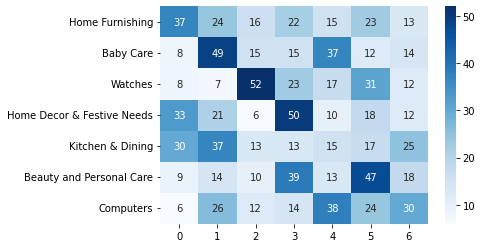

In [74]:
# Visualisation de la matrice de confusion avec un heatmap
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

Les résultats obtenus à partir de la matrice de confusion et du rapport de classification indiquent que la performance de notre modèle basé sur les techniques SIFT et OpenCV n'est pas satisfaisante. Voici les principales raisons de ce résultat et quelques remarques plausibles :

Déséquilibre des Classes : La distribution inégale des instances entre les classes peut biaiser les affectations de clusters et la classification. Certaines classes peuvent avoir plus d'instances que d'autres, ce qui incite le modèle à privilégier les classes dominantes et à moins bien performer sur les classes moins représentées.

Limitations de l'Extraction de Caractéristiques : Bien que SIFT soit une technique puissante d'extraction de caractéristiques, elle pourrait ne pas saisir les éléments distinctifs pertinents dans notre jeu de données. L'algorithme SIFT peut ne pas convenir aux distributions de données complexes ou variées, conduisant à des affectations de clusters sous-optimales.

Interprétabilité des Clusters : Il est important de déterminer si les clusters obtenus sont sémantiquement significatifs. Parfois, les clusters ne correspondent pas à l'intuition humaine, ce qui peut affecter la qualité de la classification. Il se peut que les clusters ne correspondent pas bien aux catégories de produits distinctes.

Bruits et Variabilité : Les images d'une même classe peuvent présenter des variations importantes dues aux conditions d'éclairage, aux angles, aux arrière-plans encombrés et d'autres facteurs. Cette variabilité peut entraîner des confusions lors de la classification et de l'affectation des clusters.

Réduction de Dimensionnalité : Bien que t-SNE et PCA soient utiles pour réduire la dimensionnalité, ils pourraient ne pas capturer toutes les informations nécessaires pour une classification et une affectation des clusters précises. Une réduction de la variabilité lors de la réduction de dimensionnalité peut entraîner une perte de caractéristiques importantes.

Ajustement des Hyperparamètres : Le choix des hyperparamètres, comme le nombre de clusters, peut avoir un impact significatif sur la performance. 

Données Insuffisantes : La taille du jeu de données pourrait être insuffisante pour capturer les variations complexes présentes dans les images. Plus de données diversifiées et représentatives pourraient potentiellement améliorer la performance.

Manque de Réglages Précis : Les méthodes SIFT et OpenCV nécessitent des ajustements fins et une optimisation des paramètres pour bien performer sur notre jeu de données spécifique. Les réglages par défaut utilisés dans le code pourraient ne pas être optimaux pour notre cas d'utilisation.

In [75]:
# Répertoire contenant les images
image_dir = 'Flipkart/Images/'

# Importation de la fonction 'join' depuis le module 'os.path'
from os.path import join

# Création d'une liste contenant les chemins complets vers les images
# La liste 'img_paths' va contenir les chemins vers les images correspondant à la colonne "image" du DataFrame df
img_paths = [join(image_dir, filename) for filename in df["image"].values]


In [76]:
data = pd.DataFrame({
    'image_path': img_paths,
    'category_name': df['Cat_1'],
    'label': df['label']
})

In [77]:
display(data.head(5))

,image_path,category_name,label
0,Flipkart/Images/55b85ea15a1536d46b7190ad6fff8c...,Home Furnishing,4
1,Flipkart/Images/7b72c92c2f6c40268628ec5f14c6d5...,Baby Care,0
2,Flipkart/Images/64d5d4a258243731dc7bbb1eef49ad...,Baby Care,0
3,Flipkart/Images/d4684dcdc759dd9cdf41504698d737...,Home Furnishing,4
4,Flipkart/Images/6325b6870c54cd47be6ebfbffa620e...,Home Furnishing,4


<a id='sec:analyse-transfert-apprentissage'></a>
## III. Analyse avec Transfert d'Apprentissage

#### Approche d'Extraction de Caractéristiques et de Réduction de Dimension à l'aide du Modèle Pré-entraîné VGG

Dans cette étape, nous nous concentrons sur l'extraction de caractéristiques à partir d'images en utilisant un modèle VGG16 pré-entraîné. Le modèle VGG16 a été configuré pour enlever la couche de classification supérieure, ne conservant que les couches antérieures responsables de l'extraction de caractéristiques. En parcourant chaque image dans l'ensemble de données d'entraînement, nous effectuons les étapes suivantes :

Charger l'image et la redimensionner pour qu'elle corresponde à la taille d'entrée attendue par le modèle VGG16.

Appliquer un prétraitement à l'image pour qu'elle soit compatible avec le modèle (par exemple, normalisation des valeurs des pixels).

Faire passer l'image à travers le modèle VGG16 modifié pour obtenir les activations de la couche d'extraction de caractéristiques.

Ces activations sont ensuite considérées comme les caractéristiques extraites de l'image.

Toutes les caractéristiques extraites sont rassemblées dans une liste appelée "images_features". Ensuite, nous convertissons cette liste en un tableau numpy pour faciliter la manipulation et l'analyse ultérieures. La forme du tableau résultant est imprimée pour vérification.

In [78]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

# Charger le modèle de base VGG16 pré-entraîné
base_model = VGG16()

# Créer un nouveau modèle en utilisant une partie du modèle VGG16
# Le modèle sera tronqué pour exclure la couche de sortie et conserver la couche précédente
model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)

# Afficher un résumé du modèle
print(model.summary())


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Ce code charge le modèle VGG16 pré-entraîné et crée un nouveau modèle en utilisant toutes les couches jusqu'à l'avant-dernière couche. Cela signifie que la couche de sortie du modèle VGG16 est exclue, et vous obtenez un modèle qui produit les caractéristiques extraites par le réseau VGG16 pour chaque image. Le résumé du modèle est affiché, montrant les détails des couches et du nombre de paramètres de chaque couche.

In [79]:
images_features = []
i = 0
for image_file in data["image_path"]:
    if i % 100 == 0:
        print(i)
    i += 1
    
    # Charger l'image et la prétraiter pour être compatible avec VGG16
    image = load_img(image_file, target_size=(224, 224))  # Charger l'image et redimensionner
    image = img_to_array(image)  # Convertir en tableau numpy
    image = np.expand_dims(image, axis=0)  # Ajouter une dimension pour l'axe batch
    image = preprocess_input(image)  # Prétraiter l'image pour VGG16
    
    # Extraire les caractéristiques de l'image en utilisant le modèle VGG16
    features = model.predict(image, verbose=0)[0]
    images_features.append(features)  # Ajouter les caractéristiques à la liste

# Convertir la liste de caractéristiques en un tableau numpy
images_features = np.asarray(images_features)


0
100
200
300
400
500
600
700
800
900
1000


In [80]:
# Afficher la forme du tableau des caractéristiques extraites
print(images_features.shape)

# Appliquer PCA pour réduire la dimension tout en conservant 99% de la variance
pca = decomposition.PCA(n_components=0.99)
feat_pca = pca.fit_transform(images_features)

# Afficher la forme du tableau après la réduction de dimension avec PCA
print(feat_pca.shape)


(1050, 4096)
(1050, 803)


<a id ='subsec:reduction-dimension-pca-tsne'></a>
### B. Réduction de Dimension avec t-SNE

In [81]:
# Mesurersubsec:reduction-dimension-pca-tsne le temps de début
temps1 = time.time()

# Appliquer T-SNE pour réduire la dimension à 2 composantes avec certaines options
tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

# Calculer la durée d'exécution de T-SNE
duration1 = time.time() - temps1
print("temps de T-SNE : ", "%15.2f" % duration1, "secondes")


temps de T-SNE :             4.07 secondes


<a id ='subsec:visualisation-tsne'></a>
### C. Visualisation avec t-SNE

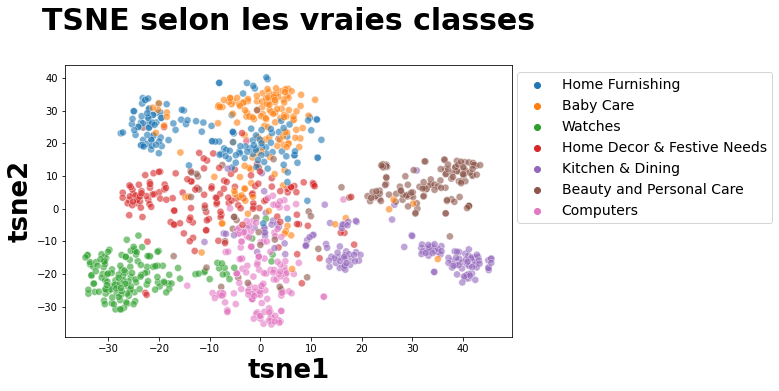

In [82]:
# Création d'un DataFrame avec les coordonnées T-SNE et les vraies classes
df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
df_tsne["class"] = data["category_name"]

# Création d'une figure de taille 8x5 pouces pour la visualisation
plt.figure(figsize=(8, 5))

# Création d'une dispersion de points colorée en utilisant Seaborn
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="class",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief"
)

# Titre du graphique
plt.title('TSNE selon les vraies classes', fontsize=30, pad=35, fontweight='bold')

# Labels des axes
plt.xlabel('tsne1', fontsize=26, fontweight='bold')
plt.ylabel('tsne2', fontsize=26, fontweight='bold')

# Légende des classes
plt.legend(prop={'size': 14}, bbox_to_anchor=(1.6, 1.0))

# Affichage du graphique
plt.show()


In [83]:
# Initialisation du modèle K-Means avec 7 clusters et 100 initialisations
cls = cluster.KMeans(n_clusters=7, n_init=100)
cls.fit(X_tsne)

KMeans(n_clusters=7, n_init=100)

In [84]:
# Assignation des labels de clusters aux données du DataFrame
df_tsne["cluster"] = cls.labels_

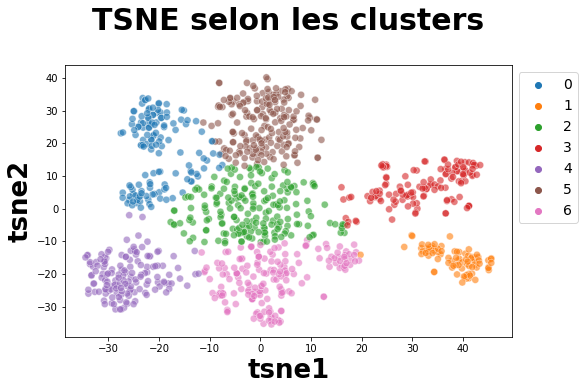

In [85]:
# Création d'une figure de taille 8x5 pouces pour la visualisation
plt.figure(figsize=(8, 5))

# Création d'une dispersion de points colorée en utilisant Seaborn
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief"
)

# Titre du graphique
plt.title('TSNE selon les clusters', fontsize=30, pad=35, fontweight='bold')

# Labels des axes
plt.xlabel('tsne1', fontsize=26, fontweight='bold')
plt.ylabel('tsne2', fontsize=26, fontweight='bold')

# Légende des clusters
plt.legend(prop={'size': 14},bbox_to_anchor=(1.0, 1.0))

# Affichage du graphique
plt.show()

In [86]:
# Labels réels des données
true_labels = data["label"]

# Calcul de l'indice ARI (Adjusted Rand Index)
ARI = np.round(metrics.adjusted_rand_score(true_labels, cls.labels_), 2)

# Calcul de l'homogénéité
homogeneity = np.round(metrics.homogeneity_score(true_labels, cls.labels_), 2)
    
# Calcul de la complétude
completeness = np.round(metrics.completeness_score(true_labels, cls.labels_), 2)
    
# Calcul de la mesure V
v_measure = np.round(metrics.v_measure_score(true_labels, cls.labels_), 2)

# Affichage des métriques de performance
print(f"ARI Score:       {ARI}\n"
      f"Homogénéité:     {homogeneity}\n"
      f"Complétude:      {completeness}\n"
      f"V-Measure:       {v_measure}\n")

ARI Score:       0.45
Homogénéité:     0.56
Complétude:      0.57
V-Measure:       0.56



In [87]:
# Calcul de la matrice de confusion entre les vraies étiquettes et les étiquettes prédites
conf_mat = metrics.confusion_matrix(true_labels, cls.labels_)
print(conf_mat)

[[  8   1  27   4   0 108   2]
 [  5   1  14 117   1   3   9]
 [  0   0  34   1   1   1 113]
 [ 54   0  82   1   6   2   5]
 [ 70   0   8   0   0  72   0]
 [  0  79  28   7   0   0  36]
 [  0   0   2   0 135   0  13]]


In [88]:
# Identification de la classe majoritaire prédite pour chaque vraie classe
majority_pred_classes = np.argmax(conf_mat, axis=0)
display(majority_pred_classes)

array([4, 5, 3, 1, 6, 0, 2])

In [89]:
# Définition de la fonction pour transformer les étiquettes prédites en utilisant la correspondance avec la classe majoritaire
def conf_mat_transform(y_true, y_pred):
    conf_mat = metrics.confusion_matrix(y_true, y_pred)
    
    # Détermination de la correspondance des clusters avec les classes majoritaires
    corresp = np.argmax(conf_mat, axis=0)
    
    print("Correspondance des clusters : ", corresp)
    
    # Transformation des étiquettes prédites en utilisant la correspondance des clusters
    labels1 = pd.Series(y_true, name="y_true").to_frame()
    labels1['y_pred'] = y_pred
    labels1['y_pred_transform'] = labels1['y_pred'].apply(lambda x: corresp[x])
    
    return labels1['y_pred_transform']

# Transformation des étiquettes prédites en utilisant la correspondance des clusters
cls_labels_transform = conf_mat_transform(true_labels, cls.labels_)

# Calcul de la nouvelle matrice de confusion avec les étiquettes transformées
conf_mat = metrics.confusion_matrix(true_labels, cls_labels_transform)
print(conf_mat)
print()

# Affichage du rapport de classification avec les nouvelles étiquettes prédites
print(metrics.classification_report(true_labels, cls_labels_transform))

Correspondance des clusters :  [4 5 3 1 6 0 2]
[[108   4   2  27   8   1   0]
 [  3 117   9  14   5   1   1]
 [  1   1 113  34   0   0   1]
 [  2   1   5  82  54   0   6]
 [ 72   0   0   8  70   0   0]
 [  0   7  36  28   0  79   0]
 [  0   0  13   2   0   0 135]]

              precision    recall  f1-score   support

           0       0.58      0.72      0.64       150
           1       0.90      0.78      0.84       150
           2       0.63      0.75      0.69       150
           3       0.42      0.55      0.48       150
           4       0.51      0.47      0.49       150
           5       0.98      0.53      0.68       150
           6       0.94      0.90      0.92       150

    accuracy                           0.67      1050
   macro avg       0.71      0.67      0.68      1050
weighted avg       0.71      0.67      0.68      1050



In [90]:
# Existing dictionary
encodage_labels = {
    'Home Furnishing': 0,
    'Baby Care': 1,
    'Watches': 2,
    'Home Decor & Festive Needs': 3,
    'Kitchen & Dining': 4,
    'Beauty and Personal Care': 5,
    'Computers': 6
}

# Desired mappings
new_mappings = {
    0: 0,
    1: 6,
    2: 5,
    3: 4,
    4: 3,
    5: 1,
    6: 2
}

# Create a new dictionary with the modified mappings
modified_encodage_labels = {key: new_mappings[value] for key, value in encodage_labels.items()}

# Sort the dictionary keys based on their values
sorted_modified_encodage_labels = {k: v for k, v in sorted(modified_encodage_labels.items(), key=lambda item: item[1])}

# Desired order
desired_order =  [4 ,1, 2, 5, 3, 6, 0]

# Create a new dictionary with the reordered keys
reordered_encodage_labels = {k: v for v, k in sorted(zip(desired_order, sorted_modified_encodage_labels.keys()))}

# Display the reordered dictionary
print(reordered_encodage_labels)

{'Baby Care': 0, 'Beauty and Personal Care': 1, 'Computers': 2, 'Home Decor & Festive Needs': 3, 'Home Furnishing': 4, 'Kitchen & Dining': 5, 'Watches': 6}


<AxesSubplot: >

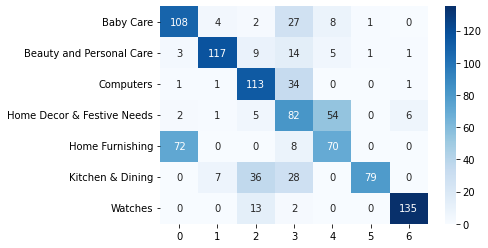

In [91]:
# Création d'un DataFrame pour la matrice de confusion
df_cm = pd.DataFrame(conf_mat, index=[label for label in list(reordered_encodage_labels.keys())],
                     columns=[i for i in "0123456"])

# Création d'une figure de taille 10x10 pouces pour la visualisation de la matrice de confusion
plt.figure(figsize=(6, 4))

# Création d'une heatmap colorée pour la matrice de confusion
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt='d')


In [92]:
# Sélection des indices des images du cluster "Watches"
ids_a_afficher = [i for i in range(len(data["image_path"])) \
                if (data.iloc[i]['category_name']=='Watches') and (df_tsne.iloc[i]['cluster']!=5)]

display(len(ids_a_afficher))

150

In [93]:
def get_label_from_number(number, encodage_labels):
    # Use a try-except block to handle cases where the number is not found in the dictionary
    try:
        label = next(key for key, value in encodage_labels.items() if value == number)
        return label
    except StopIteration:
        return None  # Return None if the number is not found in the dictionary

IndexError: index 3 is out of bounds for axis 0 with size 3

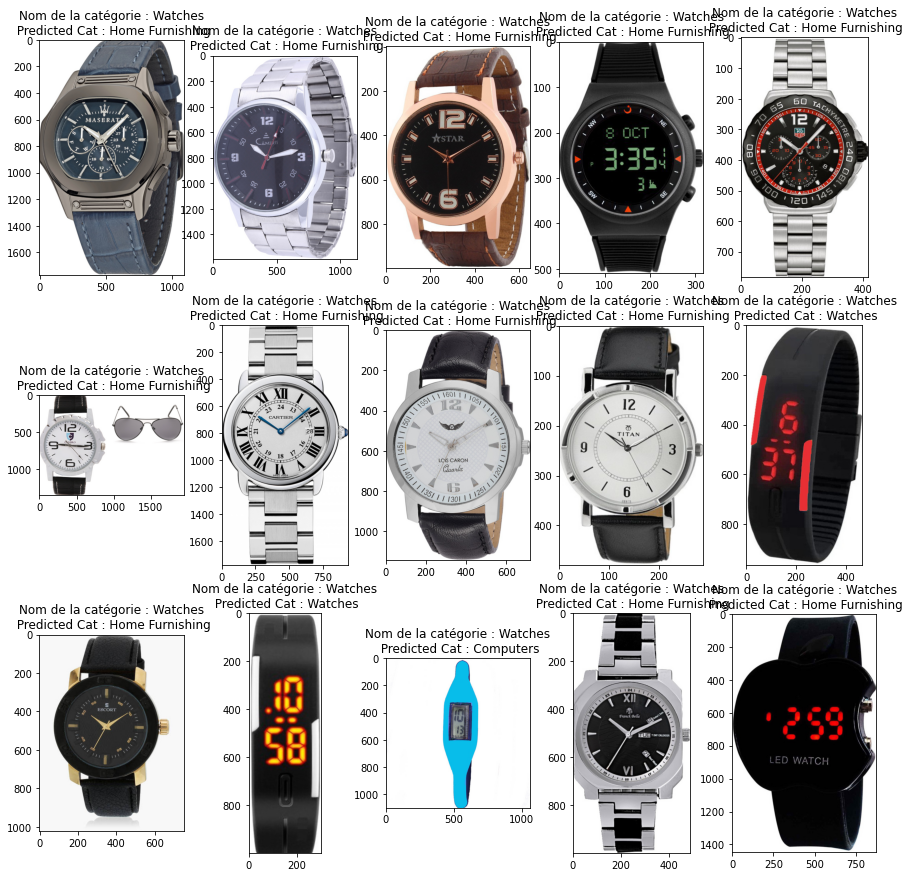

In [94]:
# Définir le nombre de lignes et de colonnes pour la grille
num_lignes = 3
num_colonnes = 5

# Créer une nouvelle figure pour la grille
fig, axes = plt.subplots(num_lignes, num_colonnes, figsize=(15, 15))

# Parcourir la liste des IDs et afficher chaque image dans un subplot
for i, id in enumerate(ids_a_afficher):
    ligne = i // num_colonnes
    colonne = i % num_colonnes

    ax = axes[ligne, colonne]
#     ax.set_title(f"ID {id}")  # Définir le titre pour afficher l'ID de l'image
    
     # Augmentez la taille et la police du titre
    cat_1 = data['category_name'][id]
    predicted_cat = df_tsne['cluster'][id]

    # Get the label for the predicted category
    predicted_label = get_label_from_number(predicted_cat, reordered_encodage_labels)#     description = df['description'][row_id]
    ax.set_title(f'Nom de la catégorie : {cat_1}\n Predicted Cat : {predicted_label}',)  # Ajustez la taille de la police selon vos préférences

    chemin_image = data["image_path"][id]  # Chemin du fichier image
    image = imread(chemin_image)  # Charger l'image
    ax.imshow(image)  # Afficher l'image

# Supprimer les subplots vides
for i in range(len(ids_a_afficher), num_lignes * num_colonnes):
    ligne = i // num_colonnes
    colonne = i % num_colonnes
    fig.delaxes(axes[ligne, colonne])

plt.tight_layout()  # Assurer un espacement approprié entre les subplots
plt.show()


<a id ='sec:conclusion'></a>
# IV. Conclusion

En conclusion, cette étude a examiné deux approches distinctes pour la classification automatisée d'images : l'utilisation de la méthode SIFT (Scale-Invariant Feature Transform) et l'application de réseaux de neurones convolutifs (CNN). Les résultats obtenus démontrent clairement la supériorité des CNN par rapport à la méthode SIFT. En effet, la méthode SIFT, bien qu'elle soit un algorithme classique pour la détection de points d'intérêt et l'extraction de descripteurs, a montré des limitations en termes de performance et de capacité à traiter des images complexes et variées. 